# Quantifying expression from RNA-seq data

This pipeline aims to call expression levels from RNA-seq data starting from `fastq.gz` sequences. It implements the GTEx pipeline for GTEx / TOPMed project. Please refer to [this page](https://github.com/broadinstitute/gtex-pipeline/blob/master/TOPMed_RNAseq_pipeline.md) for detail.

**Various reference data needs to be prepared before using this workflow**. [Here we provide a module](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/reference_data.html) to download and prepare the reference data. 

## Methods overview

> ../../images/rna_quantification.jpeg (495.9 KiB):

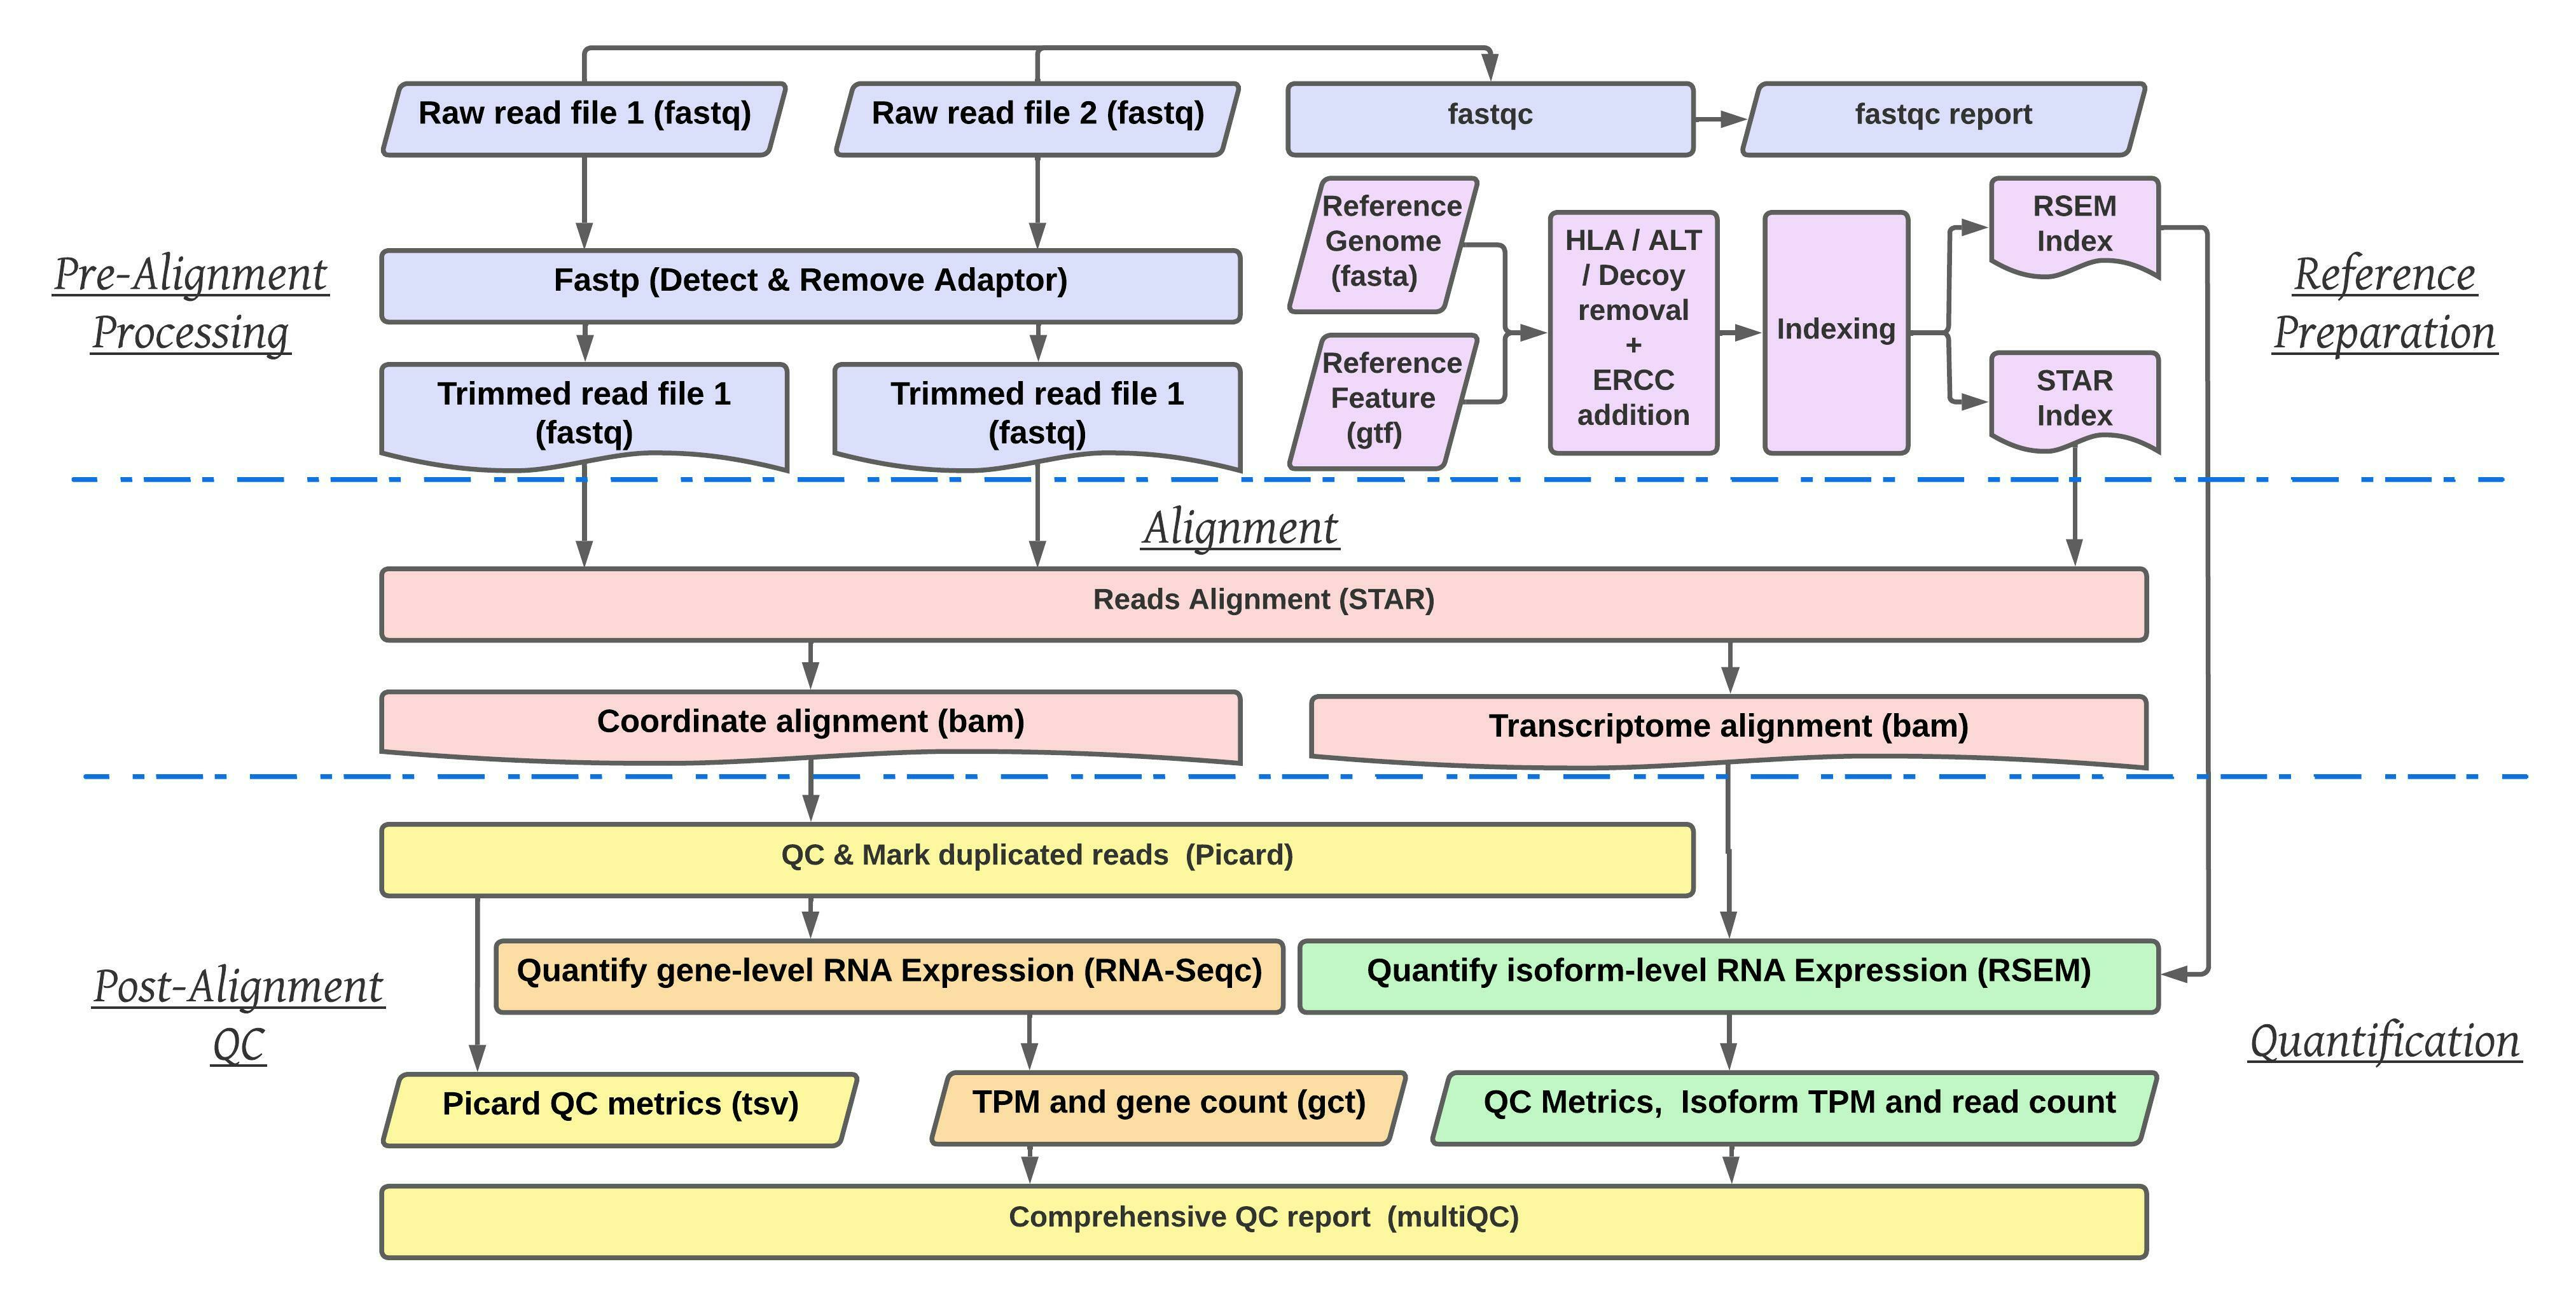

In [2]:
%preview ../../images/rna_quantification.jpeg

The procedure is decribed also in [GTEx portal](https://gtexportal.org/home/documentationPage#staticTextAnalysisMethods). Here is a recap of some important details.


### Gene-level quantifications

read counts and TPM values were produced with RNA-SeQC v2.4.2 (DeLuca et al., Bioinformatics, 2012 ), using the following read-level filters:

- Reads were uniquely mapped (corresponding to a mapping quality of 255 for START BAMs).
- Reads were aligned in proper pairs.
- The read alignment distance was <=6 (i.e., alignments must not contain more than six non-reference bases).
- Reads were fully contained within exon boundaries. Reads overlapping introns were not counted.

These filters were applied using the “-strictMode” flag in RNA-SeQC. The TPM values have not been normalized or corrected for any covariates.

### Exon-level quantifications

for exon-level read counts, if a read overlapped multiple exons, then a fractional value equal to the portion of the read contained within that exon was allotted. Transcript-level quantifications were calculated using RSEM v1.3.0.

## `strand` option

Some steps requires you specify strand option via `--strand` and should be one of`rf`, `fr` or `unstranded`. Please refer to [Signal et al (2022)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-022-04572-7) for an explanation what these library types mean. **If you are not sure about the strandedness of your data, you can use the [how_are_we_stranded_here](https://github.com/betsig/how_are_we_stranded_here) project to test and report strandedness of RNA-seq fastq files.**

## Input

A meta-data file, tab delimited with header, containing 4 columns: sample ID, fastq file 1, fastq file 2:

```
ID fq1 fq2 strands
sample_1 samp1_r1.fq.gz samp1_r2.fq.gz rf
sample_2 samp2_r1.fq.gz samp2_r2.fq.gz rf
sample_3 samp3_r1.fq.gz samp3_r2.fq.gz rf
```

All the fastq files should be available under specified folder (default assumes the same folder as where the meta-data file is).

## Output

TPM count for gene level RNA expression via `rnaseqc`, and isoform level RNA expression via `RSEM`.

## Minimal working example

A toy `fastq` data can be found on [Google Drive](https://drive.google.com/drive/u/0/folders/11kQv7PXozsKkgeqADH-28bC_kZ-w_oHo).


To generate `fastqc` report,

In [ ]:
sos run pipeline/RNA_calling.ipynb fastqc \
    --cwd output/rnaseq/fastqc \
    --samples data/sample_fastq.list \
    --data-dir data \
    --container containers/rna_quantification.sif

sos run pipeline/RNA_calling.ipynb STAR_align \
    --cwd output/rnaseq/fastqc \
    --STAR-index reference_data/STAR_Index/ \
    --gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.gene.ERCC.gtf \
    --samples data/sample_fastq.list \
    --data-dir data \
    --container containers/rna_quantification.sif -n

To call gene-level RNA expression using `rnaseqc`,
The `-J 3 -c csg.yml -q csg` part is crucial for it ask for the required memory to conduct the STAR alignment.

In [ ]:
sos run pipeline/RNA_calling.ipynb rnaseqc_call \
    --cwd output \
    --samples data/sample_fastq.list \
    --data-dir data \
    --STAR-index reference_data/STAR_Index/ \
    --gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.gene.ERCC.gtf \
    --container containers/rna_quantification.sif \
    --reference-fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy.ERCC.fasta \
    --ref-flat reference_data/Homo_sapiens.GRCh38.103.chr.reformated.ERCC.gtf.ref.flat --fasta_with_adapters_etc "Test" -n &

To call transcript level RNA expression using `RSEM`:
On a cluster, the `--mem 40G -J 3 -c csg.yml -q csg` part is crucial for it ask for the required memory to conduct the STAR alignment. However, while running on local computer, `--mem 40G` will not actually ask for 40G of mem.


In [ ]:
sos run pipeline/RNA_calling.ipynb rsem_call \
    --cwd output \
    --samples data/sample_fastq.list \
    --data-dir data \
    --STAR-index reference_data/STAR_Index/ \
    --RSEM-index reference_data/RSEM_Index/ \
    --gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.gene.ERCC.gtf \
    --container containers/rna_quantification.sif \
    --reference-fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy.ERCC.fasta \
    --ref-flat reference_data/Homo_sapiens.GRCh38.103.chr.reformated.ERCC.gtf.ref.flat  -n

In [ ]:
sos run pipeline/RNA_calling.ipynb rnaseqc_call \
    --cwd output \
    --samples data/sample_fastq.list \
    --data-dir data \
    --STAR-index reference_data/STAR_Index/ \
    --gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.gene.ERCC.gtf \
    --container containers/rna_quantification.sif \
    --reference-fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy.ERCC.fasta \
    --ref-flat reference_data/Homo_sapiens.GRCh38.103.chr.reformated.ERCC.gtf.ref.flat -n

## Command interface

In [2]:
sos run RNA_calling.ipynb -h

usage: sos run RNA_calling.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  fastqc
  fastp_trim_adaptor
  trimmomatic
  STAR_align
  rnaseqc_call
  rsem_call
  picard_qc

Global Workflow Options:
  --cwd output (as path)
                        The output directory for generated files.
  --samples VAL (as path, required)
                        Sample meta data list
  --data-dir  path(f"{samples:d}")

                        Raw data directory, default to the same directory as
                        sample list
  --job-size 1 (as int)
                        For cluster jobs, number commands to run per job
  --walltime 5h
                        Wall clock time expected
  --mem 

## Setup and global parameters

In [6]:
[global]
# The output directory for generated files.
parameter: cwd = path("output")
# Sample meta data list
parameter: samples = path
# Raw data directory, default to the same directory as sample list
parameter: data_dir = path(f"{samples:d}")
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Memory for Java virtual mechine (`picard`)
parameter: java_mem = "6G"
# Number of threads
parameter: numThreads = 8
# Software container option
parameter: container = ""
from sos.utils import expand_size
cwd = path(f'{cwd:a}')
# Reference gene model
parameter: gtf = path
import os
import pandas as pd
## FIX: The way to get sample needs to be revamped to 1. Accomodate rf/fr as column 2. accomodate single end read (Only 2 fq/samples)
sample_inv = pd.read_csv(samples,"\t")
## Extract strand information if user have specified the strand
strand_inv = []

if "strand" in sample_inv.columns:
    strand_inv = sample_inv.strand.values.tolist()
    sample_inv = sample_inv.drop("strand" , axis = 1)
    stop_if(not all([x in ["fr", "rf", "unstranded","strand_missing"] for x in strand_inv ]), msg = "strand columns should only include ``fr``, ``rf``, ``strand_missing`` or ``unstranded``")

## Extract sample_id
sample_inv_list = sample_inv.values.tolist()
sample_id = [x[0] for x in sample_inv_list]

## Get the file name for single/paired end data
file_inv = [x[1:] for x in sample_inv_list]
file_inv = [item for sublist in file_inv for item in sublist]

fastq = [f'{data_dir}/{x}' for x in file_inv]


for y in fastq:
        if not os.path.isfile(y):
            raise ValueError(f"File {y} does not exist")

if len(fastq) != len(set(fastq)):
        raise ValueError("Duplicated files are found (but should not be allowed) in fastq file list")

# Is the RNA-seq data pair-end
is_paired_end = 0 if len(fastq) == len(sample_id) else 1 
from sos.utils import env
env.logger.info(f'Input samples are {"paired-end" if is_paired_end else "single-end"} sequences.')

## Step 0: QC before alignment

This step utilize `fastqc` and will generate two QC report in `html` format

### Step Inputs

* `fastq1` and `fastq2`: paths to original `fastq.gz` file.

### Step Outputs
* Two `html` file for QC report

In [7]:
[fastqc]
input: fastq, group_by = is_paired_end + 1 
output: f'{cwd}/{_input:bnn}_fastqc.html',f'{cwd}/{_input:bnn}_fastqc/fastqc_data.txt' 
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', container=container
    fastqc ${_input} -o ${_output[0]:d}
    unzip -o ${_output[0]:n}.zip -d ${cwd}

## Step 1: Remove adaptor through `fastp`

Documentation: [fastp](https://github.com/OpenGene/fastp)

We use `fastp` in place of the `Trimmomatic` for fastp's ability to detect adapter from the reads. It was a c++ command line tool published in [Sept 2018](https://academic.oup.com/bioinformatics/article/34/17/i884/5093234). It  will use the following algorithm to detect the adaptors:
>The adapter-sequence detection algorithm is based on two assumptions: the first is that only one adapter exists in the data; the second is that adapter sequences exist only in the read tails. These two assumptions are valid for major next-generation sequencers like Illumina HiSeq series, NextSeq series and NovaSeq series. We compute the k-mer (k = 10) of first N reads (N = 1 M). From this k-mer, the sequences with high occurrence frequencies (>0.0001) are considered as adapter seeds. Low-complexity sequences are removed because they are usually caused by sequencing artifacts. The adapter seeds are sorted by its occurrence frequencies. A tree-based algorithm is applied to extend the adapter seeds to find the real complete adapter

It was demostrated that fastp can remove all the adaptor automatically and completely faster than Trimmomatic and cutadapt

### Step Inputs

* `fastq`: 1 set of fq.gz file for each sample. (2 files if paired end, 1 file if single end )

### Step Outputs
* 1 set of  `fastq.gz` file for alignment. (2 files if paired end, 1 file if single end )
* The unpaired reads (i.e.where a read survived, but the partner read did not.) will be discarded by default as those were not used in the following steps. This feature can be added were it was needed. 
* 1 set of html documenting the quality of input reads(1 html file and 1 json file)

### Step options

A few options were selected to be customizable so that fastp step can have the same level of flexiblity as the Trimmomatic step had. They are:
- min_len: length_required, reads shorter than this will be discarded, default is 15. (int [=15])
- window_size: cut_window_size, the window size option shared by cut_front, cut_tail or cut_sliding. Range: 1~1000, default: 4 (int [=4])
- leading/trailing : cut_front_mean_quality/cut_tail_mean_quality, the mean quality requirement option for cut_front/cut_tail, which move a sliding window from front/tail, drop the bases in the window if its mean quality < threshold. **Notice the choice of quality score in `fastp` (N=20) is a lot higher than that of `trimmomatic` (N=3)**. Default `fastp` setting is in line with that of [`cutadapt`](https://cutadapt.readthedocs.io/en/stable/guide.html).

The default value are set to be the same as the default value of the `fastp` software.

In [ ]:
[fastp_trim_adaptor_1]
# sliding window setting
parameter: window_size = 4
parameter: required_quality = 20
# the mean quality requirement option for cut_front
parameter: leading = 20
# the mean quality requirement option for cut_tail
parameter: trailing = 20
# reads shorter than length_required will be discarded
parameter: min_len = 15
# Path to the reference adaptors
parameter: fasta_with_adapters_etc = path(".")

warn_if(fasta_with_adapters_etc.is_file(),"Use input fasta and adaptor detection of paired-end read was disabled" )

input: fastq, group_by = is_paired_end + 1 , group_with = "sample_id"
output: [f'{cwd}/{path(x):bnn}.trimmed.fq.gz' for x in _input]
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash:  expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
        fastp -i ${f'{_input[0]} -I {_input[1]}' if is_paired_end else _input} -o ${ f'{_output[0]} -O {_output[1]}' if is_paired_end else _output } \
            ${f"--adapter_fasta {fasta_with_adapters_etc}" if fasta_with_adapters_etc.is_file() else "--detect_adapter_for_pe" }  -V -h ${_output[0]:n}.html -j ${_output[0]:n}.json -w ${numThreads} \
            --length_required ${min_len}  -W ${window_size} -M ${required_quality} -5 -3 --cut_front_mean_quality ${leading} --cut_tail_mean_quality ${leading}

In [ ]:
[fastp_trim_adaptor_2]
input: group_by = "all"
output: f'{cwd}/{samples:n}.trimmed.txt'
if is_paired_end:
    sample_inv.fq1 = [f'{x}' for x in _input:r][::2]
    sample_inv.fq2 = [f'{x}' for x in _input:r][1::2]
else:
    sample_inv.fq1 = [f'{x}' for x in _input:r]
sample_inv.to_csv(_output,"\t")

## Step 1 Alternative: Remove adaptor through `Trimmomatic`

Documentation: [Trimmomatic](http://www.usadellab.org/cms/?page=trimmomatic)

We have replaced this with `fastp`, see above, which performs better than `Trimmomatic` in terms of removing adaptors that `Trimmomatic` cannot detect. `fastp` can also automatically guess the adapter sequences from data and by default no adapter sequence is required for input to `fastp`.

### Step Inputs

* `software_dir`: directory for the software
* `fasta_with_adapters_etc`: **filename** for the adapter reference file. According to `Trimmomatic` documention,

> As a rule of thumb newer libraries will use `TruSeq3`, but this really depends on your service provider. If you use FASTQC, the "Overrepresented Sequences" report can help indicate which adapter file is best suited for your data. "Illumina Single End" or "Illumina Paired End" sequences indicate single-end or paired-end `TruSeq2` libraries, and the appropriate adapter files are `TruSeq2-SE.fa` and `TruSeq2-PE.fa` respectively. "TruSeq Universal Adapter" or "TruSeq Adapter, Index …" indicates `TruSeq-3` libraries, and the appropriate adapter files are `TruSeq3-SE.fa` or `TruSeq3-PE.fa`, for single-end and paired-end data respectively. Adapter sequences for `TruSeq2` multiplexed libraries, indicated by "Illumina Multiplexing 
…", and the various RNA library preparations are not currently included.

We have `fastqc` workflow previously defined and executed. Users should decide what fasta adapter reference to use based on `fastqc` results (or their own knowledge).

### Step Outputs
* Two paired `fastq.gz` file for alignment
* Two unpaired `fastq.gz` 

>For single-ended data, one input and one output file are specified, plus the processing steps. For paired-end data, two input files are specified, and 4 output files, 2 for the 'paired' output where both reads survived the processing, and 2 for corresponding 'unpaired' output where a read survived, but the partner read did not.


**You need to figure out from fastqc results what adapter reference sequence to use.**, eg `--fasta_with_adapters_etc TruSeq3-PE.fa`. These files can be downloaded from `Trimmomatic` github repo.

In [1]:
[trimmomatic_trim_adaptor_1]
# Path to the software. Default set to using our rna_quantification.sif image
parameter: trimmomatic_jar = "/opt/Trimmomatic-0.39/trimmomatic-0.39.jar"
# Illumina clip setting
# Path to the reference adaptors
parameter: fasta_with_adapters_etc = path(".")
parameter: seed_mismatches = 2
parameter: palindrome_clip_threshold = 30
parameter: simple_clip_threshold = 10
# sliding window setting
parameter: window_size = 4
parameter: required_quality = 20
# Other settings
parameter: leading = 3
parameter: trailing = 3
parameter: min_len = 50
input: fastq, group_by = 2, group_with = "sample_id"
output: fq_1 = f'{cwd}/{_sample_id}_paired_{_input[0]:bn}.gz',
        fq_1_up = f'{cwd}/{_sample_id}_unpaired_{_input[0]:bn}.gz',
        fq_2 = f'{cwd}/{_sample_id}_paired_{_input[1]:bn}.gz',
        fq_2_up = f'{cwd}/{_sample_id}_unpaired_{_input[1]:bn}.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    java -jar -Xmx${java_mem} ${trimmomatic_jar} PE -threads ${numThreads} \
        ${_input[0]} \
        ${_input[1]} \
        ${_output[0]} \
        ${_output[1]} \
        ${_output[2]} \
        ${_output[3]} \
        ILLUMINACLIP:${fasta_with_adapters_etc}:${seed_mismatches}:${palindrome_clip_threshold}:${simple_clip_threshold} \
        LEADING:${leading} TRAILING:${trailing} SLIDINGWINDOW:${window_size}:${required_quality} MINLEN:${min_len}

## Step 2: Alignment through `STAR`

Documentation : [STAR](https://github.com/alexdobin/STAR) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_STAR.py)

This step is the main step for `STAR` alignment. 

### Step Inputs

* paths to clean `fastq.gz` file from Step 1.
* `STAR_index`: directory for the STAR aligment index

### Step Outputs

* bam file output `${cwd}/{sample_id}.Aligned.sortedByCoord.bam`, will be used in step 3 and 4
* bam file output `${cwd}/{sample_id}.Aligned.toTranscriptome.bam`, will be used in step 5

In [1]:
[STAR_align_1]
# STAR indexing file
parameter: STAR_index = path
# Alignment parameter
parameter: outFilterMultimapNmax = 20 
parameter: alignSJoverhangMin = 8 
parameter: alignSJDBoverhangMin = 1 
parameter: outFilterMismatchNmax = 999 
parameter: outFilterMismatchNoverLmax = 0.1
parameter: alignIntronMin = 20 
parameter: alignIntronMax = 1000000 
parameter: alignMatesGapMax = 1000000 
parameter: outFilterType =  "BySJout" 
parameter: outFilterScoreMinOverLread = 0.33 
parameter: outFilterMatchNminOverLread = 0.33 
parameter: limitSjdbInsertNsj = 1200000 
parameter: outSAMstrandField = "intronMotif" 
parameter: outFilterIntronMotifs = "None" 
parameter: alignSoftClipAtReferenceEnds = "Yes" 
parameter: quantMode = ["TranscriptomeSAM", "GeneCounts"]
parameter: outSAMattrRGline = ["ID:rg1", "SM:sm1"]
parameter: outSAMattributes = ["NH", "HI", "AS", "nM", "NM", "ch"] 
parameter: chimSegmentMin = 15 
parameter: chimJunctionOverhangMin = 15 
parameter: chimOutType = ["Junctions", "WithinBAM", "SoftClip"]
parameter: chimMainSegmentMultNmax = 1 
if int(mem.replace("G","")) <  40:
    print("Insufficent memory for STAR, changing to 40G")
    star_mem = '40G'
else:
    star_mem = mem
# This option is commented out because it will force the downstream analysis to use 40G, which significantlly slow down the process.
input: fastq, group_by = is_paired_end + 1 , group_with = "sample_id"
output: cord_bam = f'{cwd}/{_sample_id}.Aligned.sortedByCoord.out.bam',
        trans_bam = f'{cwd}/{_sample_id}.Aligned.toTranscriptome.out.bam'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = star_mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # clean up before using run_STAR.py wrapper
    rm -rf ${cwd}/${_sample_id}.*.out.*.gz
    rm -rf ${cwd}/${_sample_id}._STARpass1
    run_STAR.py \
        ${STAR_index} ${_input:r}  ${_sample_id} \
        --output_dir ${cwd} \
        --outFilterMultimapNmax ${outFilterMultimapNmax} \
        --alignSJoverhangMin ${alignSJoverhangMin} \
        --alignSJDBoverhangMin ${alignSJDBoverhangMin} \
        --outFilterMismatchNmax ${outFilterMismatchNmax} \
        --outFilterMismatchNoverLmax ${outFilterMismatchNoverLmax} \
        --alignIntronMin ${alignIntronMin} \
        --alignIntronMax ${alignIntronMax} \
        --alignMatesGapMax ${alignMatesGapMax} \
        --outFilterType ${outFilterType} \
        --outFilterScoreMinOverLread ${outFilterScoreMinOverLread} \
        --outFilterMatchNminOverLread ${outFilterMatchNminOverLread} \
        --limitSjdbInsertNsj ${limitSjdbInsertNsj} \
        --outSAMstrandField ${outSAMstrandField} \
        --outFilterIntronMotifs ${outFilterIntronMotifs} \
        --alignSoftClipAtReferenceEnds ${alignSoftClipAtReferenceEnds} \
        --quantMode ${" ".join(quantMode)} \
        --outSAMattrRGline ${" ".join(outSAMattrRGline)} \
        --outSAMattributes ${" ".join(outSAMattributes)} \
        --chimSegmentMin ${chimSegmentMin} \
        --chimJunctionOverhangMin ${chimJunctionOverhangMin} \
        --chimOutType ${" ".join(chimOutType)} \
        --chimMainSegmentMultNmax ${chimMainSegmentMultNmax} \
        --annotation_gtf ${gtf} \
        --threads ${numThreads}

Following step will be automatically ran to detect the strand of input fastq file.

In [ ]:
[strand_detected_1: shared="step_strand_detected"]
input: output_from("STAR_align_1"), group_with = "sample_id"
import pandas as pd
ReadsPerGene = pd.read_csv(f'{cwd}/{_sample_id}.ReadsPerGene.out.tab.gz' , sep = "\t" , header = None )
ReadsPerGene_list = ReadsPerGene.loc[3::,].sum(axis = 0, numeric_only = True).values.tolist()
strand_percentage = [x/ReadsPerGene_list[0] for x in ReadsPerGene_list]
print(f'for sample {_sample_id}')
if strand_percentage[1] > 0.9:
    print(f'Counts for the 1st read strand aligned with RNA is {strand_percentage[1]}, > 90% of aligned count')
    print('Data is likely FR/fr-secondstrand')
    strand_detected = "fr"
elif  strand_percentage[2] > 0.9:
    print(f'Counts for the 1st read strand aligned with RNA is {strand_percentage[2]}, > 90% of aligned count')
    print('Data is likely RF/fr-firststrand')
    strand_detected = "rf"
elif max( strand_percentage[1],  strand_percentage[2]) < 0.6:
    print(f'Both {strand_percentage[1]} and  {strand_percentage[2]} are under 60% of reads explained by one direction')
    print('Data is likely unstranded')
    strand_detected = "unstranded"
else:
    print(f'Data does not fall into a likely stranded (max percent explained {max( strand_percentage[1],  strand_percentage[2])} > 0.9) or unstranded layout (max percent explained {max( strand_percentage[1],  strand_percentage[2])} < 0.6)')
    sys.exit('Exiting, please check your data and manually specified the ``--strand`` option as ``fr``, ``rf`` or ``unstranded``')

In [ ]:
[strand_detected_2: shared="strand"]
input: group_by = "all"
parameter: strand = ""
import pandas as pd
if not strand:
    if len(strand_inv) > 0:
        strand = strand_inv
        for i in range(0,len(strand)):
            if strand[i] == "strand_missing":
                strand[i] == step_strand_detected[i]
        print(f'Use strand specified in the input samples list {strand}, replacing strand_missing with detected strand')
    else:
        warn_if(not all(x is step_strand_detected[0] for x in step_strand_detected), msg = "strands detected are different among samples, please check your protocol, we will use the detected strand for each samples")    
        strand = step_strand_detected
        print(f'Use detected strand for each samples {strand}')
else:
    stop_if(strand not in ["fr", "rf", "unstranded"], msg = "``--strand`` option should be ``fr``, ``rf`` or ``unstranded``")
    print(f'Use ``--strand`` overwrite option for all the samples {strand[0]}') 
    strand = [strand] * len(step_strand_detected)

In [ ]:
[STAR_align_2]
depends: sos_variable("strand")
input: group_by = "all"
output: f'{cwd}/{samples:bn}_bam_list'
import pandas as pd
bam_list = [f'{x:b}' for x in _input["cord_bam"]]
out = pd.DataFrame({"sample_id" : sample_id,"strand" : strand , "bam_list" : bam_list })
out.to_csv(_output,sep = "\t",index = False)

## Step 3: Mark duplicates reads & QC through `Picard`

This step is the first QC step after `STAR` alignment. This step will performed QC to collect multipe metrics regarding the RNASeq using Picard. Then it will also generate a new `.bam` file with duplication marked with the hexadecimal value of `0x0400`, which corresponds to a decimal value of 1024
 




### Step Inputs:

* `STAR_bam`: path to the output in Step 2.

### Step Outputs:

* A collection of metrics file for each of the samples
* A new `.bam` file with duplication marked with the hexadecimal value of `0x0400`, which corresponds to a decimal value of 1024


In [ ]:
[rnaseqc_call_1, rsem_call_1, picard_qc]
depends: sos_variable('strand')
# Path to flat reference file, for computing QC metric
parameter: ref_flat = path()
# Path to the software. Default set to using our rna_quantification.sif image
parameter: picard_jar = "/opt/picard-tools/picard.jar"
# The fasta reference file used to generate star index
parameter: reference_fasta = path
# For the patterned flowcell models (HiSeq X), change to 2500
parameter: optical_distance = 100
input: output_from("STAR_align_1"),group_by = 2, group_with = {"sample_id","strand"}
output: picard_metrics = f'{cwd}/{_sample_id}.alignment_summary_metrics',
        md_bam = f'{cwd}/{_sample_id}.Aligned.sortedByCoord.out.md.bam',
        md_metrics = f'{cwd}/{_sample_id}.Aligned.sortedByCoord.md.metrics'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
        java -jar -Xmx${java_mem} ${picard_jar} CollectMultipleMetrics \
            -REFERENCE_SEQUENCE ${reference_fasta} \
            -PROGRAM CollectAlignmentSummaryMetrics \
            -PROGRAM CollectInsertSizeMetrics \
            -PROGRAM QualityScoreDistribution \
            -PROGRAM MeanQualityByCycle \
            -PROGRAM CollectBaseDistributionByCycle \
            -PROGRAM CollectGcBiasMetrics \
            -VALIDATION_STRINGENCY STRICT \
            -INPUT  ${_input["cord_bam"]} \
            -OUTPUT  ${_output[0]:nnn}

bash: container=container, expand= "${ }", stderr = f'{_output[-1]:n}.stderr', stdout = f'{_output[-1]:n}.stdout'
        java -Xmx${java_mem} -jar ${picard_jar} MarkDuplicates \
            -I ${_input["cord_bam"]}  \
            -O ${_output[1]} \
            -PROGRAM_RECORD_ID null \
            -M ${_output[2]} \
            -TMP_DIR ${cwd}\
            -MAX_RECORDS_IN_RAM 500000 -SORTING_COLLECTION_SIZE_RATIO 0.25 \
            -ASSUME_SORT_ORDER coordinate \
            -TAGGING_POLICY DontTag \
            -OPTICAL_DUPLICATE_PIXEL_DISTANCE ${optical_distance} \
            -CREATE_INDEX true \
            -CREATE_MD5_FILE true \
            -VALIDATION_STRINGENCY STRICT \
            -REMOVE_SEQUENCING_DUPLICATES false \
            -REMOVE_DUPLICATES false 

stop_if(not ref_flat.is_file())
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.rna_metrics.stderr', stdout = f'{_output[0]:n}.rna_metrics.stderr'
        # Get only line with rRNA and transcript_id
        cat ${gtf}| grep rRNA | grep transcript_id > ${gtf}.tmp
        samtools view -H ${_input["cord_bam"]}  > ${_input["cord_bam"]}.RI  

python: container=container, expand= "${ }", stderr = f'{_output[0]:n}.rna_metrics.stderr', stdout = f'{_output[0]:n}.rna_metrics.stderr'
        import pandas as pd
        from collections import defaultdict
        chrom = []
        start = []
        end = []
        strand = []
        tag = []
        annotation_gtf = "${gtf}.tmp"
        with open(annotation_gtf, 'r') as gtf:
            for row in gtf:
                row = row.strip().split('\t')
                if row[0][0]=='#' or row[2]!="transcript": continue # skip header
                chrom.append(row[0])
                start.append(row[3])
                end.append(row[4])
                strand.append(row[6])
                attributes = defaultdict()
                for a in row[8].replace('"', '').split(';')[:-1]:
                    kv = a.strip().split(' ')
                    if kv[0]!='tag':
                        attributes[kv[0]] = kv[1]
                    else:
                        attributes.setdefault('tags', []).append(kv[1])
                tag.append(attributes)
        transcript_id = [x["transcript_id"] for x in tag]
        RI = pd.DataFrame(data={'chr':chrom, 'start':start, 'end':end, 'strand':strand,'transcript_id' : transcript_id })
        RI.to_csv("${_input["cord_bam"]}.RI", index = 0, header = 0, mode = "a" )

bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.rna_metrics.stdout', stdout = f'{_output[0]:n}.rna_metrics.stderr'
        java -jar -Xmx${java_mem} ${picard_jar} CollectRnaSeqMetrics \
            -REF_FLAT ${ref_flat} \
            -RIBOSOMAL_INTERVALS ${_input["cord_bam"]}.RI \
            -STRAND_SPECIFICITY ${_strand} \
            -CHART_OUTPUT ${_output[0]:n}.rna_metrics.pdf \
            -VALIDATION_STRINGENCY STRICT \
            -INPUT ${_input["cord_bam"]}  \
            -OUTPUT  ${_output[0]:n}.rna_metrics
        rm ${gtf}.tmp

## Step 4: Post aligment QC through `RNA-SeQC`

Documentation : [RNA-SeQC](https://github.com/getzlab/rnaseqc) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_rnaseqc.py)

This step is second QC step after `STAR` alignment. It will perform RNA-seq quantification as well. 

### Step Inputs

* `QC_bam`: path to the output in Step 3.
* `gtf`: reference genome `.gtf` file, this gtf file need to have the same chr name format as the index used to generate the bam file and must be on collapsed gene gtf 

### Step Outputs


The following output files are generated in the output directory you provide:

* {sample}.metrics.tsv : A tab-delimited list of (Statistic, Value) pairs of all statistics and metrics recorded.

* {sample}.exon_reads.gct : A tab-delimited GCT file with (Exon ID, Gene Name, coverage) tuples for all exons which had at least part of one read mapped.

* {sample}.gene_reads.gct : A tab-delimited GCT file with (Gene ID, Gene Name, coverage) tuples for all genes which had at least one read map to at least one of its exons

* {sample}.gene_tpm.gct : A tab-delimited GCT file with (Gene ID, Gene Name, TPM) tuples for all genes reported in the gene_reads.gct file. Note: this file is renamed to .gene_rpkm.gct if the --rpkm flag is present.

* {sample}.fragmentSizes.txt : A list of fragment sizes recorded, if a BED file was provided

* {sample}.coverage.tsv : A tab-delimited list of (Gene ID, Transcript ID, Mean Coverage, Coverage Std, Coverage CV) tuples for all transcripts encountered in the GTF.


In [10]:
[rnaseqc_call_2]
depends: sos_variable('strand')
input: group_by = 3, group_with = {"sample_id","strand"}
output: f'{cwd}/{_sample_id}.rnaseqc.gene_tpm.gct.gz',
        f'{cwd}/{_sample_id}.rnaseqc.gene_reads.gct.gz',
        f'{cwd}/{_sample_id}.rnaseqc.exon_reads.gct.gz',
        f'{cwd}/{_sample_id}.rnaseqc.metrics.tsv'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    cd ${cwd} && \
    run_rnaseqc.py \
        ${gtf:a} \
        ${_input["md_bam"]:a} \
        ${_sample_id}.rnaseqc \
        -o ./ \
        ${("--stranded " + _strand) if _strand != "unstranded" else ""}

The RNASEQC results were merged in the following step,

In [ ]:
[rnaseqc_call_3]
input: group_by = "all"
output: f'{cwd}/{samples:bn}.rnaseqc.gene_tpm.gct.gz',
        f'{cwd}/{samples:bn}.rnaseqc.gene_readsCount.gct.gz',
        f'{cwd}/{samples:bn}.rnaseqc.exon_readsCount.gct.gz',
        f'{cwd}/{samples:bn}.rnaseqc.metrics.tsv'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
python: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    import pandas as pd
    import os
    def make_gct(gct_path):
        # sample_name
        sample_name = ".".join(os.path.basename(gct_path).split(".")[:-4])
        # read_input
        pre_gct = pd.read_csv(gct_path,sep = "\t",
                              skiprows= 2,index_col="Name").drop("Description",axis = 1)
        pre_gct.index.name = "gene_ID"
        pre_gct.columns = [sample_name]
        return(pre_gct)

    def merge_gct(gct_path_list):
        gct = pd.DataFrame()
        for gct_path in gct_path_list:
            #check duplicated indels and remove them.
            gct_col = make_gct(gct_path)
            gct = gct.merge(gct_col,right_index=True,left_index = True,how = "outer")
        return gct

    input_list = [${_input:r,}]
    tpm_list = input_list[0::4]
    gc_list = input_list[1::4]
    ec_list = input_list[2::4]
    gct_path_list_list = [tpm_list,gc_list,ec_list]
    output_path = [${_output:r,}][0:3]
    for i in range(0,len(output_path)):
        output = merge_gct(gct_path_list_list[i])
        output.to_csv(output_path[i], sep = "\t")
    metrics_list = input_list[3::4]
    with open("${cwd}/${samples:bn}.rnaseqc.metrics_output_list", "w") as f:
        f.write('\n'.join(metrics_list))

bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    aggregate_rnaseqc_metrics.py  ${_output[3]:n}_output_list ${_output[3]:nn}

## Step 6: Quantify expression through `RSEM`

Documentation : [RSEM](https://deweylab.github.io/RSEM/rsem-calculate-expression.html) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_RSEM.py)

This step generate the expression matrix from STAR output. Estimate gene and isoform expression from RNA-Seq data are generated.

### Step Input

* transcript-level BAM file: path to the output of Step 3.
* `RSEM_index`: path to RSEM index

### Step Outputs
Please see the output section of https://deweylab.github.io/RSEM/rsem-calculate-expression.html

In [12]:
[rsem_call_2]
depends: sos_variable('strand')
parameter: RSEM_index = path
parameter: max_frag_len = 1000
estimate_rspd = True
input: output_from("STAR_align_1"),  group_by = 2, group_with = {"sample_id","strand"} # After star there will only be two output per sample id, regardless of paired/unpaired
output: f'{cwd}/{_sample_id}.rsem.isoforms.results', f'{cwd}/{_sample_id}.rsem.genes.results',f'{cwd}/{_sample_id}.rsem.stat/{_sample_id}.rsem.cnt'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    run_RSEM.py ${RSEM_index:a} ${_input["trans_bam"]:a} ${_sample_id} \
        -o ${_output[0]:d} \
        --max_frag_len ${max_frag_len} \
        --estimate_rspd ${'true' if estimate_rspd else 'false'} \
        --paired_end ${"true" if is_paired_end else "false"} \
        --is_stranded ${"true" if _strand != "unstranded" else "false"} \
        --threads ${numThreads}

The RSEM results were merged in the following steps, seven files (four for each columns in the isoform output and 3 for each of the genes output) will be generated.

In [ ]:
[rsem_call_3]
input: group_by = "all"
output: f'{cwd}/{samples:bn}.rsem_transcripts_expected_count.txt.gz',
        f'{cwd}/{samples:bn}.rsem_transcripts_tpm.txt.gz',
        f'{cwd}/{samples:bn}.rsem_transcripts_fpkm.txt.gz',
        f'{cwd}/{samples:bn}.rsem_transcripts_isopct.txt.gz',
        f'{cwd}/{samples:bn}.rsem_genes_expected_count.txt.gz',
        f'{cwd}/{samples:bn}.rsem_genes_tpm.txt.gz',
        f'{cwd}/{samples:bn}.rsem_genes_fpkm.txt.gz',
        f'{cwd}/{samples:bn}.rsem.aggregated_quality.metrics.tsv'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads
python: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    input_list = [${_input:r,}]
    with open('${cwd}/${samples:bn}.rsem.isoforms_output_list', "w") as f:
        f.write('\n'.join(input_list[0::3]))
    with open('${cwd}/${samples:bn}.rsem.genes_output_list', "w") as f:
        f.write('\n'.join(input_list[1::3]))
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
         aggregate_rsem_results.py ${cwd}/${samples:bn}.rsem.isoforms_output_list {expected_count,TPM,FPKM,IsoPct} ${_output[0]:nnn}
         aggregate_rsem_results.py ${cwd}/${samples:bn}.rsem.genes_output_list {expected_count,TPM,FPKM} ${_output[1]:nnn} 

R:  container=container, expand= "${ }", stderr = f'{_output[-1]:n}.stderr', stdout = f'{_output[-1]:n}.stdout'
     readRSEM.cnt <- function (source) {
            # RSEM .cnt files gives statistics about the (transcriptome) alignment passed to RSEM:
            # Row 1: N0 (# unalignable reads);
            #        N1 (# alignable reads);
            #        N2 (# filtered reads due to too many alignments);
            #        N_tot (N0+N1+N2)
            # Row 2: nUnique (# reads aligned uniquely to a gene);
            #        nMulti (# reads aligned to multiple genes);
            #        nUncertain (# reads aligned to multiple locations in the given reference sequences, which include isoform-level multi-mapping reads)
            # Row 3: nHits (# total alignments);
            #        read_type (0: single-end read, no quality; 1: single-end read, with quality score; 2: paired-end read, no quality score; 3: paired-end read, with quality score)
            # Source: https://groups.google.com/forum/#!topic/rsem-users/usmPKgsC5LU
            # Note: N1 = nUnique + nMulti

            stopifnot(file.exists(source[1]))
            isDir <- file.info(source)$isdir
            if (isDir) {
                files <- system(paste("find", source, "-name \"*.rsem.cnt\""), intern=TRUE)
                stopifnot(length(files) > 0)
                samples <- gsub("_rsem.cnt", "", basename(files), fixed=TRUE)
            } else {
                files <- source
                samples <- gsub(".rsem.cnt", "", basename(files), fixed=TRUE)
            }
            metrics <- list()
            for (i in 1:length(files)) {
                m <- read.table(files[i], header=FALSE, sep=" ", comment.char="#", stringsAsFactors=FALSE, nrows=3, fill=TRUE)
                metrics[[i]] <- data.frame(Sample=samples[i],
                File=files[i],
                TotalReads=m[1, 4],
                AlignedReads=m[1, 2],
                UniquelyAlignedReads=m[2, 1],
                stringsAsFactors=FALSE)
            }
            metrics <- do.call(rbind, metrics)
            row.names(metrics) <- metrics$Sample

            return(metrics)
        }
        sourceRSEM = c(${_input:r,})
        sourceRSEM = sourceRSEM[seq(3,length(sourceRSEM),3)]
        metrics.RSEM = readRSEM.cnt(sourceRSEM)
        write.table(metrics.RSEM, file="${_output[-1]}",col.names=TRUE, row.names=FALSE, quote=FALSE)

## Step 7: summarize with MultiQC

[MultiQC](https://multiqc.info/docs/#using-multiqc) 


>MultiQC is a reporting tool that parses summary statistics from results and log files generated by other bioinformatics tools. MultiQC doesn't run other tools for you - it's designed to be placed at the end of analysis pipelines or to be run manually when you've finished running your tools. When you launch MultiQC, it recursively searches through any provided file paths and finds files that it recognises. It parses relevant information from these and generates a single stand-alone HTML report file. It also saves a directory of data files with all parsed data for further downstream use.

MultiQC will automatically generate QC report for anything embedded within the given directory. Therefore providing the directory containing all the output will surfice.

The output of MultiQC is a multi-module report each corresponding to the quality report of each step of analysis previously performed.

In [ ]:
[rsem_call_4,rnaseqc_call_4]
output: f'{cwd}/{samples:bn}.multiqc_report.html'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads
report: output = f"{_output:n}.multiqc_config.yml"
  extra_fn_clean_exts:
      - '_rsem'
  fn_ignore_dirs:
      - '*_STARpass1'
bash:  container=container,expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout' 
    multiqc ${_input:d} -v -n ${_output:b} -o ${_output:d} -c ${_output:n}.multiqc_config.yml

In [ ]:
[rsem_call_5, rnaseqc_call_5]
# Path to flat reference file, for computing QC metric
parameter: ref_flat = path()
stop_if(not ref_flat.is_file() )
output: f'{cwd}/{samples}.picard.aggregated_quality.metrics.tsv'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads
R: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    ## Define Function
    readPicard.alignment_summary_metrics <- function (source) {
      stopifnot(length(source) == 1)
      stopifnot(file.exists(source))
      isDir <- file.info(source)$isdir
      if (isDir) {
        files <- system(paste("find -L", source, "-name \"*.alignment_summary_metrics\""), intern=TRUE)
        stopifnot(length(files) > 0)
        samples <- gsub(".alignment_summary_metrics", "", basename(files), fixed=TRUE)
      } else {
        files <- source
        samples <- gsub(".alignment_summary_metrics", "", basename(files), fixed=TRUE)
      }
    
      metrics <- list()
      for (i in 1:length(files)) {
        m <- read.table(files[i], header=TRUE, sep="\t", comment.char="#", stringsAsFactors=FALSE, nrows=2)
        metrics[[i]] <- data.frame(Sample=samples[i],
                                   File=files[i],
                                   PF_READS=sum(m$PF_READS[1:2]),
                                   PF_READS_ALIGNED=sum(m$PF_READS_ALIGNED[1:2]),
                                   PCT_PF_READS_ALIGNED=sum(m$PF_READS_ALIGNED[1:2])/sum(m$PF_READS[1:2]),
                                   stringsAsFactors=FALSE)
      }
      metrics <- do.call(rbind, metrics)
      row.names(metrics) <- metrics$Sample
    
      return(metrics)
    }

    readPicard.rna_metrics <- function(source) {

      stopifnot(length(source) == 1)
      stopifnot(file.exists(source))
      isDir <- file.info(source)$isdir
      if (isDir) {
        files <- system(paste("find -L", source, "-name \"*.rna_metrics\""), intern=TRUE)
        stopifnot(length(files) > 0)
        samples <- gsub(".rna_metrics", "", basename(files), fixed=TRUE)
      } else {
        files <- source
        samples <- gsub(".rna_metrics", "", basename(files), fixed=TRUE)
      }

      metrics <- list()
      for (i in 1:length(files)) {
        m <- read.table(files[i], header=TRUE, sep="\t", comment.char="#", stringsAsFactors=FALSE, nrows=1)
        metrics[[i]] <- data.frame(Sample=samples[i],
                                   File=files[i],
                                   PCT_RIBOSOMAL_BASES=m$PCT_RIBOSOMAL_BASES,
                                   PCT_CODING_BASES=m$PCT_CODING_BASES,
                                   PCT_UTR_BASES=m$PCT_UTR_BASES,
                                   PCT_INTRONIC_BASES=m$PCT_INTRONIC_BASES,
                                   PCT_INTERGENIC_BASES=m$PCT_INTERGENIC_BASES,
                                   PCT_MRNA_BASES=m$PCT_MRNA_BASES,
                                   PCT_USABLE_BASES=m$PCT_USABLE_BASES,
                                   MEDIAN_CV_COVERAGE=m$MEDIAN_CV_COVERAGE,
                                   MEDIAN_5PRIME_BIAS=m$MEDIAN_5PRIME_BIAS,
                                   MEDIAN_3PRIME_BIAS=m$MEDIAN_3PRIME_BIAS,
                                   MEDIAN_5PRIME_TO_3PRIME_BIAS=m$MEDIAN_5PRIME_TO_3PRIME_BIAS,
                                   stringsAsFactors=FALSE)
      }
      metrics <- do.call(rbind, metrics)
      row.names(metrics) <- metrics$Sample
    
      return(metrics)
    }


    readPicard.duplicate_metrics <- function(source) {

      stopifnot(length(source) == 1)
      stopifnot(file.exists(source))
      isDir <- file.info(source)$isdir
      if (isDir) {
        files <- system(paste("find -L", source, "-name \"*.Aligned.sortedByCoord.md.metrics\""), intern=TRUE)
        stopifnot(length(files) > 0)
        samples <- gsub(".Aligned.sortedByCoord.md.metrics", "", basename(files), fixed=TRUE)
      } else {
        files <- source
        samples <- gsub(".Aligned.sortedByCoord.md.metrics", "", basename(files), fixed=TRUE)
      }

      metrics <- list()
      for (i in 1:length(files)) {
        m <- read.table(files[i], header=TRUE, sep="\t", comment.char="#", stringsAsFactors=FALSE, nrows=1)
        metrics[[i]] <- data.frame(Sample=samples[i],
                                   File=files[i],
                                   PERCENT_DUPLICATION=m$PERCENT_DUPLICATION,
                                   ESTIMATED_LIBRARY_SIZE=m$ESTIMATED_LIBRARY_SIZE,
                                   stringsAsFactors=FALSE)
      }
      metrics <- do.call(rbind, metrics)
      row.names(metrics) <- metrics$Sample
    
      return(metrics)
    }

    readPicard.wgs_metrics <- function (source) {

      stopifnot(length(source) == 1)
      stopifnot(file.exists(source))
      isDir <- file.info(source)$isdir
      if (isDir) {
        files <- system(paste("find -L", source, "-name \"*.wgs_metrics\""), intern=TRUE)
        stopifnot(length(files) > 0)
        samples <- gsub(".wgs_metrics", "", basename(files), fixed=TRUE)
      } else {
        files <- source
        samples <- gsub(".wgs_metrics", "", basename(files), fixed=TRUE)
      }

      metrics <- list()
      for (i in 1:length(files)) {
        m <- read.table(files[i], header=TRUE, sep="\t", comment.char="#", stringsAsFactors=FALSE, nrows=1)
        metrics[[i]] <- data.frame(Sample=samples[i],
                                   File=files[i],
                                   MEDIAN_COVERAGE=m$MEDIAN_COVERAGE,
                                   MAD_COVERAGE=m$MAD_COVERAGE,
                                   PCT_EXC_DUPE=m$PCT_EXC_DUPE,
                                   PCT_EXC_TOTAL=m$PCT_EXC_TOTAL,
                                   stringsAsFactors=FALSE)
      }
      metrics <- do.call(rbind, metrics)
      row.names(metrics) <- metrics$Sample

      return(metrics)
    }


    readPicard.insert_size_metrics <- function (source) {

      stopifnot(length(source) == 1)
      stopifnot(file.exists(source))
      isDir <- file.info(source)$isdir
      if (isDir) {
        files <- system(paste("find -L", source, "-name \"*.insert_size_metrics\""), intern=TRUE)
        stopifnot(length(files) > 0)
        samples <- gsub(".insert_size_metrics", "", basename(files), fixed=TRUE)
      } else {
        files <- source
        samples <- gsub(".insert_size_metrics", "", basename(files), fixed=TRUE)
      }

      metrics <- list()
      for (i in 1:length(files)) {
        m <- read.table(files[i], header=TRUE, sep="\t", comment.char="#", stringsAsFactors=FALSE, nrows=1)
        metrics[[i]] <- data.frame(Sample=samples[i],
                                   File=files[i],
                                   MEDIAN_INSERT_SIZE=m$MEDIAN_INSERT_SIZE,
                                   MODE_INSERT_SIZE=m$MODE_INSERT_SIZE,
                                   MEDIAN_ABSOLUTE_DEVIATION=m$MEDIAN_ABSOLUTE_DEVIATION,
                                   stringsAsFactors=FALSE)
      }
      metrics <- do.call(rbind, metrics)
      row.names(metrics) <- metrics$Sample
    
      return(metrics)
    }

    readPicard.gc_bias.summary_metrics <- function (source) {

      stopifnot(length(source) == 1)
      stopifnot(file.exists(source))
      isDir <- file.info(source)$isdir
      if (isDir) {
        files <- system(paste("find -L", source, "-name \"*.gc_bias.summary_metrics\""), intern=TRUE)
        stopifnot(length(files) > 0)
        samples <- gsub(".gc_bias.summary_metrics", "", basename(files), fixed=TRUE)
      } else {
        files <- source
        samples <- gsub(".gc_bias.summary_metrics", "", basename(files), fixed=TRUE)
      }

      metrics <- list()
      for (i in 1:length(files)) {
        m <- read.table(files[i], header=TRUE, sep="\t", comment.char="#", stringsAsFactors=FALSE, nrows=1)
        metrics[[i]] <- data.frame(Sample=samples[i],
                                   File=files[i],
                                   AT_DROPOUT=m$AT_DROPOUT,
                                   GC_DROPOUT=m$GC_DROPOUT,
                                   stringsAsFactors=FALSE)
      }
      metrics <- do.call(rbind, metrics)
      row.names(metrics) <- metrics$Sample

      return(metrics)
    }




    readPicard <- function(source) {
      metrics.aln <- readPicard.alignment_summary_metrics(source)
      metrics.rna <- readPicard.rna_metrics(source)
      metrics.dup <- readPicard.duplicate_metrics(source)

      stopifnot(all(row.names(metrics.aln) %in% row.names(metrics.rna)) &
                all(row.names(metrics.rna) %in% row.names(metrics.dup)) &
                all(row.names(metrics.dup) %in% row.names(metrics.aln)))

      metrics.aln$File <- NULL
      metrics.rna$File <- NULL
      metrics.dup$File <- NULL
      metrics.rna$Sample <- NULL
      metrics.dup$Sample <- NULL

      metrics <- cbind(metrics.aln, metrics.rna[row.names(metrics.aln), ])
      metrics <- cbind(metrics, metrics.dup[row.names(metrics.aln), ])

      return(metrics)
    }

    ## Execution  
    sourcePicard = ${_input[-1]:dr}

    Picard_qualityMetrics <- readPicard(sourcePicard)
    write.table(Picard_qualityMetrics, file="${_output}",col.names=TRUE, row.names=FALSE, quote=FALSE)